In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [14]:
# Splitting MNIST dataset into train and test sets
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [15]:
def same_padding(kernel_size, stride=1):
    # For odd dimensions, we can pad evenly on both sides
    # For even dimensions, we will pad one more on the right/bottom side
    pad_val = (kernel_size - stride) // 2
    return (pad_val, pad_val + (kernel_size % 2 - 1))


def create_sparse_representations(batch, sparsity=0.5):
    # Function to create sparse representations and masks for a batch of images
    masks = torch.bernoulli(torch.ones_like(batch) * (1 - sparsity))
    sparse_batch = batch * masks
    return sparse_batch, masks


In [9]:
class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        
    def forward(self, input, mask):
        # Apply convolution to the input
        output = self.conv(input * mask)
        # Create a new mask
        new_mask = F.conv2d(mask, torch.ones_like(self.conv.weight), None, self.conv.stride, self.conv.padding)
        new_mask = torch.ceil(new_mask.clamp_(0, 1))
        
        # Normalize the output by the number of valid inputs
        epsilon = 1e-5
        output = output / (new_mask + epsilon)
        
        return output, new_mask

class SparseInvariantCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            SparseConv2d(1, 16, kernel_size=11, padding=same_padding(11)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=11, stride=1, padding=same_padding(11)),
            SparseConv2d(16, 16, kernel_size=7, padding=same_padding(7)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=7, stride=1, padding=same_padding(7)),
            SparseConv2d(16, 16, kernel_size=5, padding=same_padding(5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1, padding=same_padding(5)),
            SparseConv2d(16, 16, kernel_size=3, padding=same_padding(3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
            SparseConv2d(16, 16, kernel_size=3, padding=same_padding(3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
            SparseConv2d(16, 10, kernel_size=1, padding=same_padding(1)),
            nn.ReLU()
        )

    def forward(self, x, mask):
        for layer in self.features:
            if isinstance(layer, SparseConv2d):
                x, mask = layer(x, mask)
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)
        return x

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = SparseInvariantCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accs = []
test_accs = []
epochs = 5

def evaluate_accuracy(data_loader, net):
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)

            sparse_images, masks = create_sparse_representations(images, sparsity=0.5)
            sparse_images, masks = sparse_images.to(device), masks.to(device)
            outputs = net(sparse_images, masks)  # Only one output is expected
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# Training loop
for epoch in range(epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Create sparse representations and masks
        sparse_images, masks = create_sparse_representations(images, sparsity=0.5)
        sparse_images, masks = sparse_images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = net(sparse_images, masks)
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = evaluate_accuracy(train_loader, net) * 100
    train_accs.append(train_acc)
    test_acc = evaluate_accuracy(test_loader, net) * 100
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

print('Finished Training')


Epoch 1/5
Loss: 1.7993, Training Accuracy: 62.10%, Test Accuracy: 62.28%
Epoch 2/5
Loss: 0.7890, Training Accuracy: 82.77%, Test Accuracy: 83.47%
Epoch 3/5
Loss: 0.5016, Training Accuracy: 84.89%, Test Accuracy: 85.29%
Epoch 4/5
Loss: 0.4108, Training Accuracy: 88.33%, Test Accuracy: 88.69%
Epoch 5/5
Loss: 0.3654, Training Accuracy: 90.29%, Test Accuracy: 90.36%
Finished Training


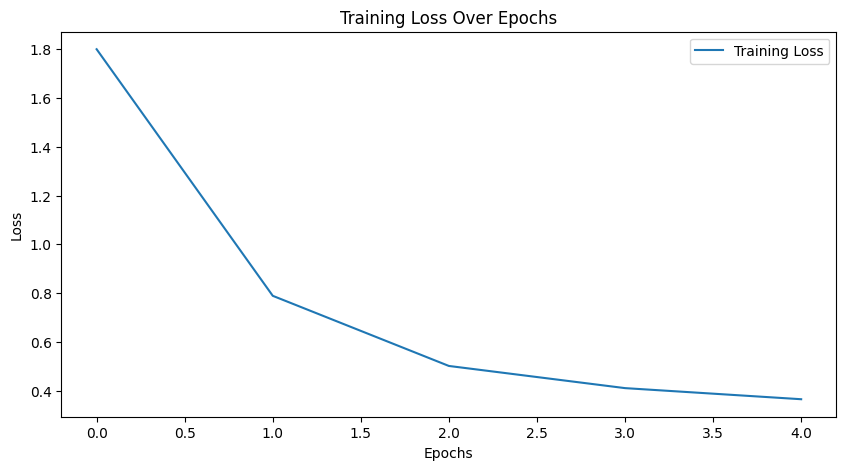

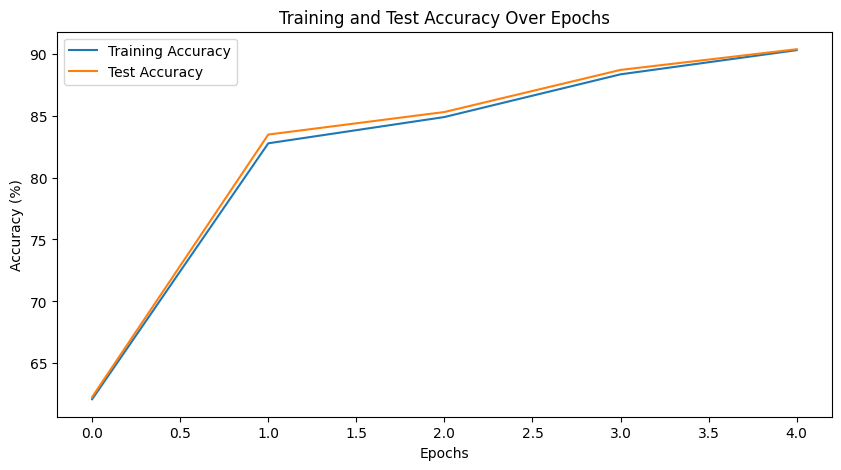

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [19]:
class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        
    def forward(self, input, mask):
        # Apply convolution 
        output = self.conv(input * mask)

        new_mask = F.conv2d(mask, torch.ones_like(self.conv.weight), None, self.conv.stride, self.conv.padding)
        new_mask = torch.ceil(new_mask.clamp_(0, 1))
        
        # Normalize
        epsilon = 1e-5
        output = output / (new_mask + epsilon)
        
        return output, new_mask
    
    def backward(self, dupstream):
        """
        Backward pass of convolutional layer: calculate gradients of loss with
        respect to weight and bias and return downstream gradient dx.
        
        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        # You don't need to implement the backward pass. Instead we give it to
        # you the solution.

        # Unpack cache
        mask_padded = self.cache_mask # This is for the mask
        x_padded = self.cache_input #This is for the convLayer

        # Create an empty dx tensor to accumulate the gradients on. Keep in mind
        # that it has a size according to padded input
        dx_padded = torch.zeros_like(x_padded)

        # Also initialize the weight gradients as zeros
        self.weight_grad = torch.zeros_like(self.weight)

        # Unpack needed dimensions
        N, _, Hp, Wp = dupstream.shape

        # Loop through dupstream
        for i in range(Hp):
            for j in range(Wp):

                # Calculate offset for current window on input
                h_offset = i * self.stride
                w_offset = j * self.stride

                # Get current window of input and gradient of the input
                window = x_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]
                dwindow = dx_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]

                # mask_window = mask_padded[:, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]
                # # Walk through each sample of the input and accumulate gradients
                # # of both input and weight
                # valid_pixels_amount = mask_window.sum()
                # if valid_pixels_amount > 0:
                for k in range(N):
                    dwindow[k] += (self.weight * dupstream[k, :, i, j].view(-1, 1, 1, 1)).sum(dim=0)
                    self.weight_grad += window[k].view(1, self.in_channels, self.kernel_size, self.kernel_size) * dupstream[k, :, i, j].view(-1, 1, 1, 1)
        # Calculate actual size of input height and width
        H = x_padded.shape[2] - 2 * self.padding
        W = x_padded.shape[3] - 2 * self.padding

        # Unpad dx
        dx = dx_padded[:, :, self.padding:self.padding+H, self.padding:self.padding+W]

        # Calculate bias gradients
        self.bias_grad = dupstream.sum(dim=(0, 2, 3))

        return dx
    
class SparseInvariantCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            SparseConv2d(1, 16, kernel_size=11, padding=same_padding(11)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=11, stride=1, padding=same_padding(11)),
            SparseConv2d(16, 16, kernel_size=7, padding=same_padding(7)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=7, stride=1, padding=same_padding(7)),
            SparseConv2d(16, 16, kernel_size=5, padding=same_padding(5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1, padding=same_padding(5)),
            SparseConv2d(16, 16, kernel_size=3, padding=same_padding(3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
            SparseConv2d(16, 16, kernel_size=3, padding=same_padding(3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
            SparseConv2d(16, 10, kernel_size=1, padding=same_padding(1)),
            nn.ReLU()
        )

    def forward(self, x, mask):
        for layer in self.features:
            if isinstance(layer, SparseConv2d):
                x, mask = layer(x, mask)
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)  # Flatten 
        return x

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = SparseInvariantCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accs = []
test_accs = []
epochs = 5

def evaluate_accuracy(data_loader, net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)

            sparse_images, masks = create_sparse_representations(images, sparsity=0.5)
            sparse_images, masks = sparse_images.to(device), masks.to(device)
            outputs = net(sparse_images, masks)  # Only one output is expected
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# Training loop
for epoch in range(epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        sparse_images, masks = create_sparse_representations(images, sparsity=0.5)
        sparse_images, masks = sparse_images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = net(sparse_images, masks)
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = evaluate_accuracy(train_loader, net) * 100
    train_accs.append(train_acc)
    test_acc = evaluate_accuracy(test_loader, net) * 100
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

print('Finished Training')


Epoch 1/5
Loss: 1.8327, Training Accuracy: 63.17%, Test Accuracy: 64.22%
Epoch 2/5
Loss: 0.7875, Training Accuracy: 81.92%, Test Accuracy: 82.65%
Epoch 3/5
Loss: 0.5272, Training Accuracy: 84.44%, Test Accuracy: 85.53%
Epoch 4/5
Loss: 0.4355, Training Accuracy: 88.13%, Test Accuracy: 88.70%
Epoch 5/5
Loss: 0.3812, Training Accuracy: 88.27%, Test Accuracy: 88.78%
Finished Training


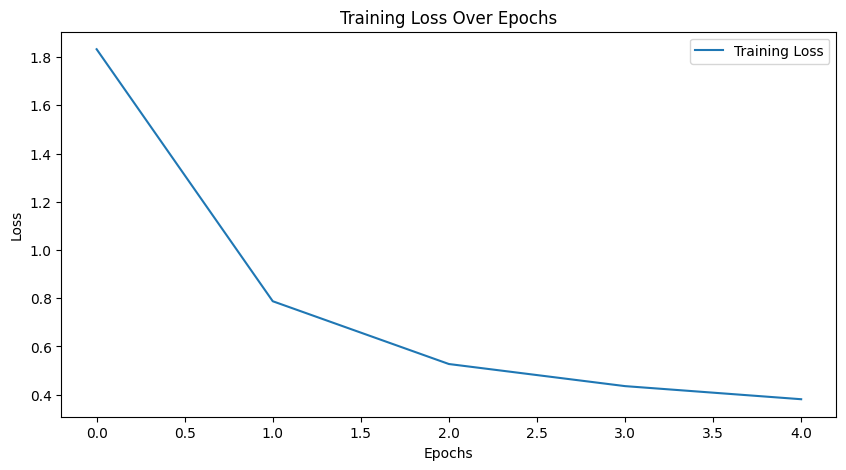

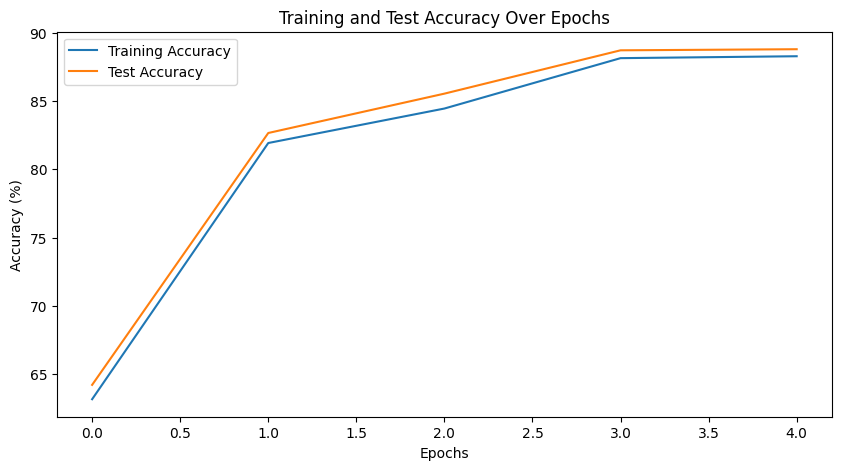

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [ ]:
#TODO: Implement the function calculate_mae for table 3
# Debug the function calculate_mae
def calculate_mae(model, data_loader, device):
    model.eval()
    total_mae = 0.0
    total_count = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            mae = torch.abs(outputs - labels).mean()  # MAE calculation
            total_mae += mae.item() * images.size(0)
            total_count += images.size(0)

    average_mae = total_mae / total_count
    return average_mae

sparsity_levels = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
results = {}

for sparsity in sparsity_levels:
    model = SparseInvariantCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            sparse_images, masks = create_sparse_representations(images, sparsity)
            sparse_images, masks = sparse_images.to(device), masks.to(device)
            outputs = model(sparse_images, masks)
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1} completed for sparsity {sparsity*100}%')

    mae_performance = calculate_mae(model, test_loader, device)
    print(f'MAE at {sparsity*100}% sparsity: {mae_performance}')
    results[sparsity] = mae_performance

for sparsity, mae in results.items():
    print(f'Sparsity: {sparsity*100}%, MAE: {mae}')


Apparently, implementing backward pass besides using the subclass torch.autograd.Function i.e. PyTorch's automatic differentiation engine, autograd, will handle the backward pass is better in accuracy metric

In [ ]:
# TODO: visualize the results like in the paper and compare the results with the paper?